In [ ]:
# !unzip ../data/validation/validation_data.zip

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


In [2]:
pip install -r requirements.in --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd

# Load DEA Coastlines code
import coastlines.validation




In [ ]:
!python -m coastlines.validation --help

In [ ]:
!python -m coastlines.validation --inputs_path data/validation/interim/wrl_narrabeen --deacl_path data/processed/tests/coastlines_tests.gpkg --prefix tests --append_stats True --markdown_report True

  0%|          | 0/1 [00:00<?, ?it/s]

Skipping; file either exists or overwrite set to false


Combining data


TypeError: cannot unpack non-iterable NoneType object

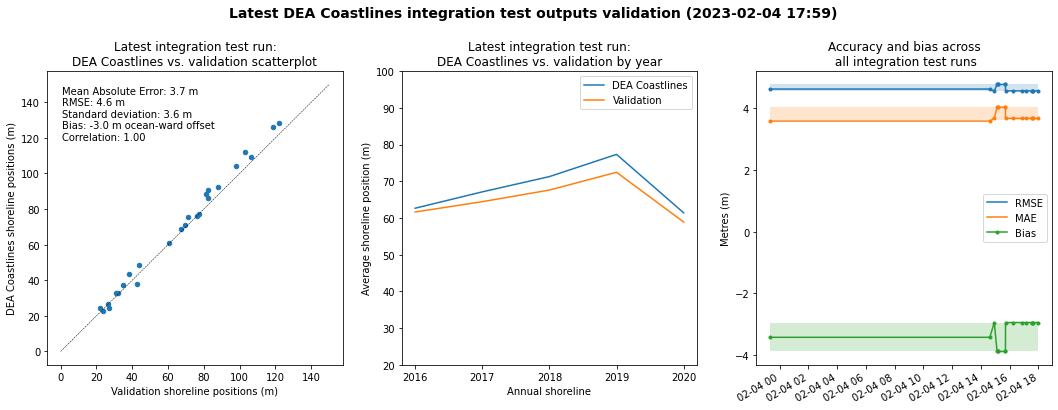

In [188]:
outputs_df, stats_df = coastlines.validation.validation_cli(
    inputs_path="data/validation/interim/wrl_narrabeen",
    deacl_path="data/processed/tests/coastlines_tests.gpkg",
    prefix="tests",
    datum="0",
    overwrite=False,
    layer_name='shorelines_annual',
    append_stats=True,
    parallelised=True,
    markdown_report=True)
    

prefix='tests'
deacl_path="data/processed/tests/coastlines_tests.gpkg"

In [149]:
stats_df.drop('name', axis=1).iloc[-1] - stats_df.drop('name', axis=1).iloc[-1]

n        714.000
mae        3.680
rmse       4.570
stdev      3.570
corr       0.996
bias      -2.950
Name: 2023-02-04 17:35:45.240882+11:00, dtype: float64

In [184]:
recent_diff

n                   no change
mae                 no change
rmse                no change
stdev               no change
corr     deteriorated by -0.2
bias                no change
dtype: object

n                   no change
mae                 no change
rmse                no change
stdev               no change
corr     deteriorated by -0.2
bias                no change
dtype: object

In [187]:
from mdutils.mdutils import MdUtils
from mdutils import Html

# Calculate recent change
recent_diff = stats_df.drop("name", axis=1).diff(1).iloc[-1].to_frame("diff")
recent_diff.iloc[2] = 1.4
recent_diff.iloc[4] = -0.2
recent_diff.loc[recent_diff["diff"] < 0, "prefix"] = "deteriorated by "
recent_diff.loc[recent_diff["diff"] == 0, "prefix"] = "no change"
recent_diff.loc[recent_diff["diff"] > 0, "prefix"] = "improved by "
recent_diff["suffix"] = recent_diff["diff"].replace({0: ""})
recent_diff = recent_diff.prefix.astype(str) + recent_diff.suffix.astype(str)

mdFile = MdUtils(file_name="tests/README.md", title="Latest integration test results")
mdFile.new_paragraph(
    f"The latest integration test completed at **{str(stats_df.index[-1])[0:16]}**. "
    f"Compared to the previous run, it had an RMSE accuracy of **{stats_df.rmse[-1]} m ({recent_diff.rmse})**, an MAE accuracy of **{stats_df.mae[-1]} m ({recent_diff.mae})**, and a Pearson correlation of **{stats_df['corr'][-1]} ({recent_diff['corr']})**."
)
mdFile.new_paragraph(Html.image(path=f"stats_tests.png", size="850"))
mdFile.create_md_file()

In [145]:
f"The latest integration test ({str(stats_df.index[-1])[0:16]}) ha"

'The latest integration test (2023-02-04 17:35) ha'

In [125]:
# coastlines.validation.export_eval(outputs_df, output_name='test', output_crs="EPSG:3577")

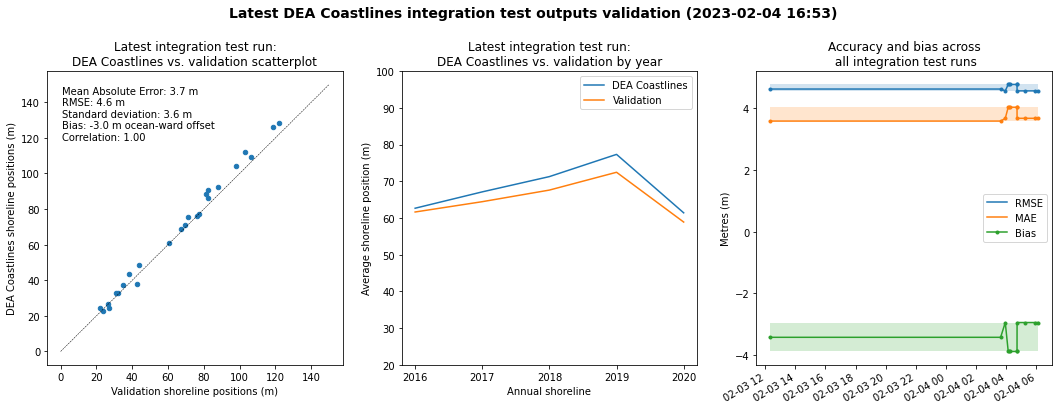

In [139]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Extract integration test run times and convert to local time
# times_local = stats_df.index.tz_localize("UTC").tz_convert(tz="Australia/Canberra")
# stats_df.index = times_local



# Compute stats  
n, mae, rmse, stdev, corr, bias, _ = stats_df.iloc[-1]
offset_str = 'landward offset' if bias > 0 else 'ocean-ward offset'

# Plot latest integration test results as scatterplot
outputs_df.plot.scatter(ax=axes[0], x="val_dist", y="deacl_dist")
axes[0].plot([0, 150], [0, 150], linestyle="--", color="black", linewidth=0.5)
axes[0].set_title(
    "Latest integration test run:\nDEA Coastlines vs. validation scatterplot"
)
axes[0].set_ylabel("DEA Coastlines shoreline positions (m)")
axes[0].set_xlabel("Validation shoreline positions (m)")
# axes[0].annotate(str(stats_df.iloc[-1]),
#             xy=(0.1, 0.9), xycoords='axes fraction',
#             horizontalalignment='left', 
#             verticalalignment='top')


axes[0].annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.05, 0.95),
                    horizontalalignment='left', 
                    verticalalignment='top',
                    xycoords='axes fraction')

# Plot latest integration test results by year
outputs_df.groupby("year").deacl_dist.mean().rename("DEA Coastlines").plot(ax=axes[1], legend=True)
outputs_df.groupby("year").val_dist.mean().rename("Validation").plot(ax=axes[1], legend=True)
axes[1].set_ylim((20, 100))
axes[1].set_title(
    f"Latest integration test run:\nDEA Coastlines vs. validation by year"
)
axes[1].set_ylabel("Average shoreline position (m)")
axes[1].set_xlabel("Annual shoreline")
axes[1].set_xticks(outputs_df.year.unique())

# Plot all integration test accuracies and biases over time
stats_df.rmse.rename("RMSE").plot(ax=axes[2], style=".-", legend=True)
min_q, max_q = stats_df.rmse.quantile((0.1, 0.9)).values
axes[2].fill_between(stats_df.index, min_q, max_q, alpha=0.2)

stats_df.mae.rename("MAE").plot(ax=axes[2], style=".-", legend=True)
min_q, max_q = stats_df.mae.quantile((0.1, 0.9)).values
axes[2].fill_between(stats_df.index, min_q, max_q, alpha=0.2)

stats_df.bias.rename("Bias").plot(ax=axes[2], style=".-", legend=True)
min_q, max_q = stats_df.bias.quantile((0.1, 0.9)).values
axes[2].fill_between(stats_df.index, min_q, max_q, alpha=0.2)
axes[2].set_title("Accuracy and bias across\n all integration test runs")
axes[2].set_ylabel("Metres (m)")
axes[2].set_xlabel(None)

# Add overall title
plt.suptitle(
    f"Latest DEA Coastlines integration test outputs validation ({str(times_local[-1])[0:16]})",
    size=14,
    fontweight="bold",
    y=1.03,
);

plt.savefig(f"data/validation/processed/stats_{prefix}.png",  bbox_inches="tight")

n        714.0
mae       3.68
rmse      4.57
stdev     3.57
corr     0.996
bias     -2.95
name     tests
Name: 2023-02-04 16:53:48.046406+11:00, dtype: object

Timestamp('2023-02-04 14:43:01.183111+1000', tz='Australia/Brisbane')

In [ ]:
# import geopandas as gpd
# plt.figure(figsize=(10, 10))
# gpd.read_file(deacl_path).plot(ax=plt.gca(), column='year', cmap='magma')

In [ ]:
outputs_df.groupby("year").val_dist.mean().plot()
(outputs_df.groupby("year").deacl_dist.mean()).plot()

In [ ]:
outputs_df

In [ ]:
!python -m coastlines.validation --inputs_path data/validation/interim/cgc --deacl_path data/releases/coastlines_v0.0.3.gpkg --prefix v0.0.3 --append_stats False

In [ ]:
import glob
prefix='v0.0.3'

print('Combining data')
stats_list = glob.glob(f'data/validation/processed/outputs_{prefix}_*.csv')
stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])

# Rename smartline categories to smaller subset
stats_df['smartline'] = stats_df.smartline.replace(rename_dict)

# Run stats
stats_df = coastlines.validation.deacl_val_stats(stats_df.val_dist,
                stats_df.deacl_dist,
                n=stats_df.n,
                remove_bias=False)
# print(stats_df.T)
# stats_df.T.to_csv(f'data/validation/processed/stats_{prefix}.csv')

In [ ]:
# !python -m pytest tests/ -v

In [ ]:
val_df = coastlines.validation.deacl_validation(val_path='data/validation/interim/2020test_narrabeen.csv', deacl_path='data/releases/coastlines_v0.0.3.gpkg', datum=0, prefix='test', overwrite=True, layer_name='shorelines_annual')

In [ ]:
!wget https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_coastlines/v0.0.3/coastlines_v0.0.3.gpkg -P data/releases

In [ ]:
!wget https://data.dea.ga.gov.au/derivative/dea_coastlines/1-1-0/DEACoastlines_gpkg_v1.1.0.zip -P data/releases

In [ ]:
!unzip data/releases/DEACoastlines_gpkg_v1.1.0.zip data/releases

In [ ]:
import glob

val_paths = glob.glob('data/validation/interim/*2020test_narrabeen.csv')

prefix = 'v0.0.3'
deacl_path = 'data/releases/coastlines_v0.0.3.gpkg'
layer_name = 'shorelines_annual'

# prefix = 'v1.1.0'
# deacl_path = 'data/releases/DEACoastlines_v1.1.0.gpkg'
# layer_name = 'DEACoastlines_annualshorelines_v1.1.0'

In [ ]:
  
# Non-parallel (for testing)
for val_path in val_paths:
#     try:
    coastlines.validation.deacl_validation(val_path=val_path, deacl_path=deacl_path, datum=0, prefix=prefix, overwrite=True, layer_name=layer_name)
#     except:
#         print

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from itertools import repeat

args = [deacl_path, 0, prefix, True]

with ProcessPoolExecutor() as executor:

    # Apply func in parallel
    groups = val_paths
    to_iterate = (groups, *(repeat(i, len(groups)) for i in args))
    tqdm(executor.map(coastlines.validation.deacl_validation, *to_iterate), total=len(groups))


In [ ]:
# Load all results into a single file
print('Combining data')
stats_list = glob.glob(f'data/validation/processed/{prefix}_*.csv')
stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])

# Rename smartline categories to smaller subset
stats_df['smartline'] = stats_df.smartline.replace(rename_dict)

# Export to file
# stats_df.to_csv('deacl_results.csv', index=False)

# Run stats
coastlines.validation.deacl_val_stats(stats_df.val_dist,
                          stats_df.deacl_dist,
                          n=stats_df.n,
                          remove_bias=True)

In [ ]:
v111 = stats_df.groupby('year').apply(lambda x: coastlines.validation.deacl_val_stats(x.val_dist,
                          x.deacl_dist,
                          n=x.n,
                          remove_bias=True))

In [ ]:
# Load all results into a single file
print('Combining data')
stats_list = glob.glob(f'data/validation/processed/{prefix}_*.csv')
stats_df = pd.concat([pd.read_csv(csv) for csv in stats_list])

# Rename smartline categories to smaller subset
stats_df['smartline'] = stats_df.smartline.replace(rename_dict)

# Export to file
# stats_df.to_csv('deacl_results.csv', index=False)

# Run stats
coastlines.validation.deacl_val_stats(stats_df.val_dist,
                          stats_df.deacl_dist,
                          n=stats_df.n,
                          remove_bias=True)

In [ ]:
v200 = stats_df.groupby('year').apply(lambda x: coastlines.validation.deacl_val_stats(x.val_dist,
                          x.deacl_dist,
                          n=x.n,
                          remove_bias=True))

In [ ]:
v111.rmse.rename('v1.1.0').plot(legend=True)
v200.rmse.rename('v2.0.0').plot(legend=True)

In [ ]:
# Stats by substrate, no bias correction
by_smartline = stats_df.query("n >= 22").groupby('smartline').apply(
    lambda x: coastlines.validation.deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_smartline_nobias = stats_df.query("n >= 22").groupby('smartline').apply(
    lambda x: coastlines.validation.deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

out = coastlines.validation.rse_tableformat(by_smartline, by_smartline_nobias, 'smartline')
out

In [ ]:
# Stats by substrate, no bias correction
by_smartline = stats_df.query("n < 22").groupby('smartline').apply(
    lambda x: coastlines.validation.deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_smartline_nobias = stats_df.query("n < 22").groupby('smartline').apply(
    lambda x: coastlines.validation.deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

out = coastlines.validation.rse_tableformat(by_smartline, by_smartline_nobias, 'smartline')
out

In [ ]:
# !pip install git+https://github.com/GeoscienceAustralia/dea-intertidal.git

In [ ]:
from intertidal import validation

In [ ]:
validation.eval_metrics(x=stats_df.val_dist, y=stats_df.deacl_dist)

In [ ]:
by_source = stats_df.groupby('source').apply(
    lambda x: coastlines.validation.deacl_val_stats(x.val_dist, x.deacl_dist, x.n))
by_source_nobias = stats_df.groupby('source').apply(
    lambda x: coastlines.validation.deacl_val_stats(x.val_dist, x.deacl_dist, x.n, True))

coastlines.validation.rse_tableformat(by_source, by_source_nobias)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Print stats and plot scatterplot
stats_subset = stats_df  


def val_plot(df, 
             title='Validation',
             scatter=True, 
             density=False,
             time=True, 
             time_stat='mean',
             time_legend_pos=[0.8, 0.035],
             offset=0,
             extent=(0, 120),
             scatter_kwargs={}, 
             time_kwargs={}):
    
    # Copy data and apply offset
    df = df.copy()
    df['error_m'] += offset
    df['deacl_dist'] += offset

    # Compute stats  
    n, mae, rmse, stdev, corr, bias = coastlines.validation.deacl_val_stats(
        val_dist=df.val_dist, 
        deacl_dist=df.deacl_dist)    
    offset_str = 'landward offset' if bias > 0 else 'ocean-ward offset'

    if scatter:
        
        # Plot data as scatterplot
        fig, ax = plt.subplots(figsize=(8, 8))
        df.plot.scatter(x='val_dist',
                        y='deacl_dist',
                        s=15,
                        edgecolors='black',
                        linewidth=0,
#                         xlim=extent,
#                         ylim=extent,
                        ax=ax,
                        **scatter_kwargs)
        
        # Add dashed line
        
        
        ax.plot(
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                np.linspace(df.loc[:, ['deacl_dist', 'val_dist']].values.min(), 
                            df.loc[:, ['deacl_dist', 'val_dist']].values.max()),
                color='black',
                linestyle='dashed')
        
        ax.set_xlabel(f'{title} (metres along profile)')
        ax.set_ylabel(f'DEA Coastlines (metres along profile)')
        
        # Add annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Set title
        plt.gca().set_title(f'DEA Coastlines vs {title}', weight='bold')
        
        # Export to file        
        fig.savefig(f"{title}_scatter_offset{offset:.1f}.png", dpi=300)
        
    if density:
        
        fig, ax = plt.subplots(figsize=(8, 8))

        g = sns.kdeplot(ax=ax,
                        data=df.val_dist,
                        data2=df.deacl_dist, 
                        cmap='YlOrRd', 
                        shade=True,
                        bw=3,
                        shade_lowest=False,
                        clip=(extent, extent))

        g.set(xlabel=f'{title} (metres along profile)', 
              ylabel=f'DEA Coastlines (metres along profile)')
        ax.set_title(f'DEA Coastlines vs {title}', weight='bold')

        # Add stats annotation
        ax.annotate(f'Mean Absolute Error: {mae:.1f} m\n' \
                    f'RMSE: {rmse:.1f} m\n' \
                    f'Standard deviation: {stdev:.1f} m\n' \
                    f'Bias: {bias:.1f} m {offset_str}\n' \
                    f'Correlation: {corr:.2f}\n',
                    xy=(0.04, 0.75),
                    fontsize=14,
                    xycoords='axes fraction')

        # Add diagonal line
        plt.gca().plot(np.linspace(*extent), 
                       np.linspace(*extent),
                       color='black',
                       linestyle='dashed')
        
        plt.gca().set_ylim(bottom=extent[0])
        plt.gca().set_xlim(left=extent[0])

        # Export to file
        fig = g.get_figure()
        fig.savefig(f"{title}_heatmap_offset{offset:.1f}.png", dpi=300)
        
    if time:
        
        # Group by beach and apply statistic
        stats_grouped = (df.groupby(['beach', 'year'], as_index=False)
                         .aggregate(time_stat)
                         .rename({'beach': 'id',
                                  'deacl_dist': 'DEA Coastlines',
                                  'val_dist': title}, axis=1)
                         .groupby('id')
                         .filter(lambda x: len(x) > 1))

        # Melt data into long format for faceted plotting
        stats_melted = pd.melt(stats_grouped, 
                               id_vars=['id', 'year'],
                               value_vars=['DEA Coastlines', title],
                               value_name='Distance (m)')

        # Plot facet data
        g = sns.relplot(data=stats_melted,
                        x="year", 
                        y="Distance (m)", 
                        col="id", 
                        hue="variable",
                        height=1.7, 
                        aspect=1.0, 
                        kind="line", 
                        legend='full', 
                        col_wrap=5,
                        **time_kwargs)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(f'DEA Coastlines vs {title}', 
                       weight='bold', 
                       ha='right')
        
        # Simplify titles
        g.set_titles(row_template='{row_name}', 
                     col_template='{col_name}')

        # Customise legend
        g._legend.texts[0].set_text("")
        g._legend.set_bbox_to_anchor(time_legend_pos)
        
        # Export to file
        g.savefig(f"{title}_time_offset{offset:.1f}.png", dpi=300)
        
    return pd.Series({'Mean Absolute Error': mae, 
                    f'RMSE': rmse,
                    f'Standard deviation': stdev,
                    f'Bias': f'{bias:.1f} m {offset_str}',
                    f'Correlation': corr})

# for i, sub in stats_subset.groupby('smartline'):

#     # Run analysis
#     g = val_plot(df=sub,  # stats_subset,
#                  title=i.replace('/', '-'),
#                  scatter=True, 
#                  density=False,
#                  time=False,
#                  time_stat='median',
#                  time_legend_pos=[0.67, 0.11],
#                  offset=0,
#                  extent=(0, 1000))

# Run analysis
g = val_plot(df=stats_subset,  # stats_subset,
         title='',
         scatter=True, 
         density=False,
         time=False,
         time_stat='median',
         time_legend_pos=[0.67, 0.11],
         offset=0,
         extent=(0, 300))